In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
import  warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import GradientBoostingClassifier
from  sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder ,OneHotEncoder ,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

np.random.seed(10)

In [2]:
train_path ="./train.csv"
test_path = "./test.csv"
train_data = pd.read_csv(train_path )
train_data.head(5)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1000009418151094273,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,10000169349117863715,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,10000371904215119486,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,10000640724480838376,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,10000679056417042096,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


In [3]:
train_data.drop('hour'  ,axis  =1 ,  inplace= True )

In [4]:
train_data.drop('id'  ,axis  =1 ,  inplace= True )

In [5]:
strings_features  = list(train_data.columns[train_data.dtypes =="object"])
for  feature in strings_features :
    encoder = LabelEncoder()
    train_data[feature] = encoder.fit_transform(train_data[feature] )

In [6]:
y,X = train_data.pop('click') ,train_data 
for  feature  in   X.columns:
    encoder = StandardScaler()
    train_data[feature] = encoder.fit_transform(train_data[feature].
                                                values.reshape( -1, 1))
X_train,X_test , y_train , y_test  =  train_test_split(X,y, 
                                                       test_size  = 0.2 )
# 再将训练集拆成两个部分（GBDT/RF，LR）
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train, y_train, 
                                                            test_size=0.5)

In [7]:
display( X_train.shape,
        y_train.shape ,
        X_test.shape, 
        y_test.shape  )


(19999, 21)

(19999,)

(10000, 21)

(10000,)

In [8]:
y_test

18069    0
42840    0
4796     0
3648     1
34714    0
        ..
46346    0
9566     0
8894     0
39282    1
18186    1
Name: click, Length: 10000, dtype: int64

In [9]:
# 基于GBDT监督变换
n_estimator =500 
grd = GradientBoostingClassifier(learning_rate= 0.01,
                                 n_estimators=n_estimator ,
                                 max_depth= 3 )
grd.fit(X_train, y_train)
# 得到OneHot编码
grd_enc = OneHotEncoder(categories='auto')

#temp = grd.apply(X_train)
np.set_printoptions(threshold=np.inf)  
grd_enc.fit(grd.apply(X_train)[:, :, 0])
#print(grd_enc.get_feature_names()) # 查看每一列对应的特征
# 使用OneHot编码作为特征，训练LR
grd_lm = LogisticRegression(solver='lbfgs', max_iter=1000)
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)
# 使用LR进行预测
y_pred_grd_lm = grd_lm.predict_proba(grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)


<Figure size 432x288 with 0 Axes>

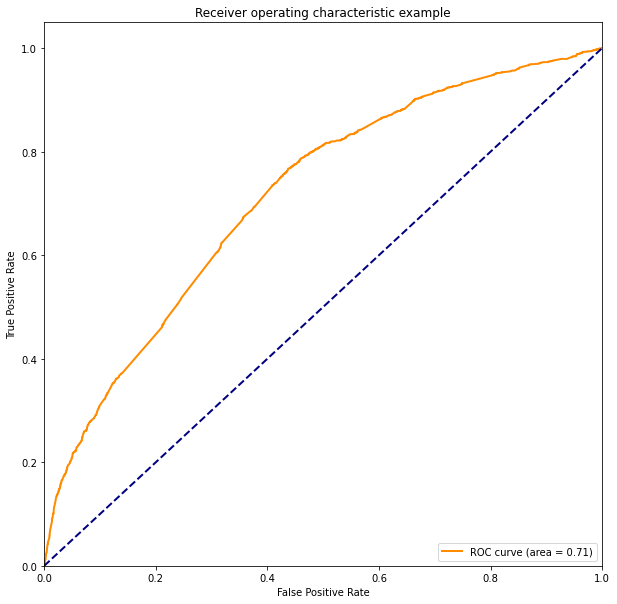

In [10]:
roc_auc =auc(fpr_grd_lm, tpr_grd_lm) 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr_grd_lm, tpr_grd_lm, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
